In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time
import sys

print(torch.cuda.is_available())
print(torch.cuda.get_device_name())


True
Quadro P1000


In [2]:
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.transform = transform
        self.base_dir = base_dir
    
    def __getitem__(self, idx):
        label = idx % 10
        index = idx // 10
        img_name = str(index) + '.png'
        
        image = self.load_image(os.path.join('Dataset', 'training', str(label), img_name))
        output = [0] * 10
        output[label] = 1
        
        data = {
                    'image': torch.FloatTensor(image),
                    'label' : torch.LongTensor(output)
               }
        
        return data
    
    def load_image(self, path=None):
        raw_image = Image.open(path)
        raw_image = raw_image.convert('L')
        
        return (np.array(raw_image, dtype=np.float32)/255.0).flatten()
    
    def __len__(self):
        #return sum([len(os.listdir(os.path.join('Dataset', 'training', digit))) for digit in np.arange(0, 10).astype(str)])
        return 54200

In [87]:
class FCNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_channels, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, output_channels)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.softmax(x)

In [89]:
NUM_INPUT_CHANNELS = 28 * 28
NUM_OUTPUT_CHANNELS = 10

NUM_EPOCHS = 10
LEARNING_RATE = 1e-5
MOMENTUM = 0.8
BATCH_SIZE = 32

train_dataset = MNISTDataset(base_dir='.')

print(train_dataset.__getitem__(1)['image'].size())

train_dataloader = DataLoader(train_dataset,
                                  batch_size=BATCH_SIZE,
                                  shuffle=True,
                                  num_workers=0)

if torch.cuda.is_available():
    model = FCNet(input_channels=28 * 28, output_channels=10).cuda()
    criterion = torch.nn.CrossEntropyLoss().cuda()
else:
    print('Error: Cuda was not available')
    
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, amsgrad=True)


torch.Size([784])


In [90]:
model.train()

print("Training:")
prev_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    print("Epoch #{}".format(epoch+1))

    t_start = time.time()
    running_loss = 0.0

    for idx, batch in enumerate(train_dataloader):
        input_tensor, target_tensor = batch['image'], batch['label']

        input_tensor = input_tensor.cuda()
        target_tensor = target_tensor.cuda()

        predicted_tensor = model(input_tensor)
        target_tensor = torch.argmax(target_tensor, dim=1)

        optimizer.zero_grad()
        loss = criterion(predicted_tensor, target_tensor)
        loss.backward()
        optimizer.step()

        running_loss += loss.float()

        if idx % 100 == 0:
            print("\r\tBatch progress: {:.2f}% [{}/{}]".format((idx/len(train_dataloader))*100, idx, len(train_dataloader), end=''))
            sys.stdout.flush()

    delta = time.time() - t_start
    print("\tLoss: {:.8f}\tTime: {:.8f}".format(running_loss, delta))


Training:
Epoch #1
	Batch progress: 0.00% [0/1694]


c:\users\amoros\miniconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


	Batch progress: 5.90% [100/1694]
	Batch progress: 11.81% [200/1694]
	Batch progress: 17.71% [300/1694]
	Batch progress: 23.61% [400/1694]
	Batch progress: 29.52% [500/1694]
	Batch progress: 35.42% [600/1694]
	Batch progress: 41.32% [700/1694]
	Batch progress: 47.23% [800/1694]
	Batch progress: 53.13% [900/1694]
	Batch progress: 59.03% [1000/1694]
	Batch progress: 64.94% [1100/1694]
	Batch progress: 70.84% [1200/1694]
	Batch progress: 76.74% [1300/1694]
	Batch progress: 82.64% [1400/1694]
	Batch progress: 88.55% [1500/1694]
	Batch progress: 94.45% [1600/1694]
	Loss: 3711.62841797	Time: 44.79150224
Epoch #2
	Batch progress: 0.00% [0/1694]
	Batch progress: 5.90% [100/1694]
	Batch progress: 11.81% [200/1694]
	Batch progress: 17.71% [300/1694]
	Batch progress: 23.61% [400/1694]
	Batch progress: 29.52% [500/1694]
	Batch progress: 35.42% [600/1694]
	Batch progress: 41.32% [700/1694]
	Batch progress: 47.23% [800/1694]
	Batch progress: 53.13% [900/1694]
	Batch progress: 59.03% [1000/1694]
	Bat

In [112]:
#torch.save(model.state_dict(), os.path.join('.', 'test.pth'))
np.set_printoptions(precision=5)
np.set_printoptions(suppress=True)

[0.      0.      0.      0.      0.99979 0.      0.00018 0.      0.
 0.00002]
tensor(4)


c:\users\amoros\miniconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


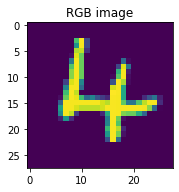

In [117]:
model.eval()

dataiter = iter(train_dataloader)
test = dataiter.next()

image_id = 0

image, labels = test['image'], test['label']
tensor = image[image_id]
character = tensor.reshape([28,28])

fig = plt.figure(figsize=(12,12))

fig.add_subplot(1,4,1).title.set_text('RGB image')
plt.imshow(character.permute(0, 1))

image = tensor.cuda()

output = model(image)

prediction = output.cpu()

print(prediction.detach().numpy())
print(prediction.argmax())

In [87]:
for digit in np.arange(0, 10).astype(str):
    print(digit)
    for idx, filename in enumerate(os.listdir(os.path.join('Dataset', 'training', digit))):
        os.rename(os.path.join('Dataset', 'training', digit, filename), os.path.join('Dataset', 'training', digit, str(idx) + '.png'))

print('done')

0
1
2
3
4
5
6
7
8
9
done


In [99]:
print (sum([len(os.listdir(os.path.join('Dataset', 'training', digit))) for digit in np.arange(0, 10).astype(str)]))


54200
